# Setup dataset

In [1]:
import pandas as pd
import os

ANNOTATIONS_PATH = 'data'
REPROCESSED_PATH = ANNOTATIONS_PATH+'/reprocessed'
with open(ANNOTATIONS_PATH+'/annotationsVSingle.txt','r') as file:
    annotations = [line for line in file.read().splitlines()[1:]]

sampleAnno = 0
def read_data(id: int):
    if '(A)' in annotations[id] or '(B)' in annotations[id]:
        folder, trial, fragId, _, OoM = annotations[id].replace(' ','').split(',')[:5]
    else:
        folder, trial, fragId, OoM = annotations[id].replace(' ','').split(',')[:4]
    file = os.path.join(REPROCESSED_PATH, folder, trial+'_frag'+fragId+'.csv')
    table = pd.read_csv(file)
    return table, OoM
dataTable,_ = read_data(sampleAnno)
dataTable.head()

,right_foot_X,right_foot_Y,right_foot_Z,left_foot_X,left_foot_Y,left_foot_Z,right_ank_X,right_ank_Y,right_ank_Z,left_ank_X,...,right_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,left_shoulder_X,left_shoulder_Y,left_shoulder_Z,head_X,head_Y,head_Z
0,0.603479,0.282036,0.196394,0.599149,0.282866,0.281366,0.634263,0.311879,0.185018,0.626746,...,0.178245,0.610581,0.753321,0.244585,0.608132,0.749503,0.310926,0.620697,0.841934,0.245584
1,0.603481,0.282036,0.196393,0.599149,0.282867,0.281366,0.634298,0.311807,0.185099,0.626744,...,0.178267,0.610508,0.753349,0.244600,0.608137,0.749526,0.310933,0.620695,0.841926,0.245566
2,0.603482,0.282037,0.196392,0.599149,0.282866,0.281365,0.634445,0.311722,0.185230,0.626739,...,0.178288,0.610425,0.753376,0.244616,0.608147,0.749552,0.310944,0.620691,0.841918,0.245548
3,0.603482,0.282036,0.196392,0.599152,0.282863,0.281364,0.633893,0.311849,0.184935,0.626735,...,0.178300,0.610346,0.753399,0.244627,0.608150,0.749578,0.310954,0.620685,0.841909,0.245532
4,0.603481,0.282040,0.196393,0.599150,0.282868,0.281363,0.634368,0.311826,0.185111,0.626724,...,0.178315,0.610267,0.753423,0.244642,0.608158,0.749599,0.310969,0.620681,0.841904,0.245516


In [2]:
def table_to_list_xyz_tables(table:pd.DataFrame,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]
    
def group_table_by_joints(table: pd.DataFrame) -> pd.DataFrame:
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

In [3]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.stats import iqr

def extractFeatures(features):
  raw_features = features.shape[1]
  arr = features
  energy = np.sqrt(np.sum(arr ** 2, axis=0))
  fft = np.fft.fft(arr, axis=0)
  amplitude_spectrum = np.abs(fft)
  phase_angle = np.angle(fft) 

  frq_info = [
              phase_angle[0, :],
              np.mean(fft.real, axis=0),
              np.max(fft.real, axis=0),
              np.argmax(fft.real, axis=0),
              np.min(fft.real, axis=0),
              np.argmin(fft.real, axis=0),
              skew(amplitude_spectrum, axis=0, bias=True),
              kurtosis(amplitude_spectrum, axis=0, bias=True),
  ] 

  frq_info = np.hstack(frq_info)
  mean = np.mean(arr, axis=0)
  var = np.var(arr, axis=0)
  kurt = kurtosis(arr, axis=0, bias=True)
  skew_ = skew(arr, axis=0, bias=True)
  corr = np.corrcoef(arr, rowvar=False)[np.triu_indices(raw_features,k=1)]
  mad = np.mean(np.abs(arr - mean), axis=0)
  sem = np.std(arr, axis=0) / np.sqrt(arr.shape[0])
  mi = np.min(arr, axis=0)
  ma = np.max(arr, axis=0)
  return np.hstack([mean,var,kurt,skew_,corr,mad,sem,energy,iqr(arr,axis=0),mi,ma,frq_info])

def get_feature_names(raw_features):#df, metadata):
  #df_raw_feat = df.columns
  new_names = [] #new_names = list(df_raw_feat[:metadata])
  #raw_features = df_raw_feat[metadata:]

  # Define the feature names based on the order they appear in extractFeatures
  new_names += [f"mean_{i}" for i in raw_features]
  new_names += [f"var_{i}" for i in raw_features]
  new_names += [f"kurt_{i}" for i in raw_features]
  new_names += [f"skew_{i}" for i in raw_features]
  new_names += [f"corr_{i_name}_{j_name}" for i, i_name in enumerate(raw_features[:-1]) for j, j_name in enumerate(raw_features[i+1:])]
  new_names += [f"mad_{i}" for i in raw_features]
  new_names += [f"sem_{i}" for i in raw_features]
  new_names += [f"energy_{i}" for i in raw_features]
  new_names += [f"iqr_{i}" for i in raw_features]
  new_names += [f"min_{i}" for i in raw_features]
  new_names += [f"max_{i}" for i in raw_features]

  new_names += [f"fft_phase_angle_{i}" for i in raw_features]
  new_names += [f"fft_mean_real{i}" for i in raw_features]
  new_names += [f"fft_max_real{i}" for i in raw_features]
  new_names += [f"fft_argmax_real{i}" for i in raw_features]
  new_names += [f"fft_min_real{i}" for i in raw_features]
  new_names += [f"fft_argmin_real{i}" for i in raw_features]
  new_names += [f"fft_skew_amp_spec{i}" for i in raw_features]
  new_names += [f"fft_kurt_amp_spec{i}" for i in raw_features]

  return new_names

In [4]:
OoM_set = set([tuple(map(int, read_data(i)[1].strip('[]').split('-'))) for i in range(len(annotations))])
OoM_to_ord = dict(zip(sorted(list(OoM_set)),range(len(annotations))))
ord_to_OoM = dict(zip(range(len(annotations)),sorted(list(OoM_set))))
OoM_to_ord

{(1, 3): 0,
 (2, 4): 1,
 (3, 5): 2,
 (5, 7): 3,
 (6, 9): 4,
 (7, 8): 5,
 (8, 9): 6,
 (11, 13): 7,
 (12, 14): 8,
 (13, 15): 9,
 (15, 17): 10,
 (16, 19): 11,
 (17, 18): 12,
 (18, 19): 13,
 (18, 20): 14}

Works on single labels

In [5]:
import numpy as np 
from tqdm.notebook import tqdm 

feature_names = get_feature_names([col[:-2] for col in dataTable.columns[::3]])

dataset = pd.DataFrame(index=range(len(annotations)), columns=feature_names+['OoM'])

for i in tqdm(range(-len(annotations)),desc='Computing features for the dataset'):
    dataTable,OoM = read_data(i)
    centerOfMassPosTable = pd.concat([table.apply(lambda row: row.mean(),axis=1) for table in table_to_list_xyz_tables(dataTable)],axis=1)
    centerOfMassPosTable.columns = ['X','Y','Z']
    centerOfMassPosTable = centerOfMassPosTable.apply(lambda row: (row['X'], row['Y'], row['Z']), axis=1)
    tableByJoint = group_table_by_joints(dataTable)
    jointsDistFromCOM = tableByJoint.sub(centerOfMassPosTable,axis=0)
    jointsDistNorm = jointsDistFromCOM.applymap(lambda elem: np.linalg.norm(elem))
    jointsDistNormMin, jointsDistNormMax = jointsDistNorm.min(axis=0), jointsDistNorm.max(axis=0)
    jointsDistNorm = (jointsDistNorm-jointsDistNormMin)/(jointsDistNormMax-jointsDistNormMin)
    featureVector = extractFeatures(np.array(jointsDistNorm))
    dataset.loc[i] = np.hstack([featureVector,OoM_to_ord[tuple(map(int, OoM.strip('[]').split('-')))]])
dataset

Computing features for the dataset:   0%|          | 0/60 [00:00<?, ?it/s]

,mean_right_foot,mean_left_foot,mean_right_ank,mean_left_ank,mean_right_knee,mean_left_knee,mean_right_hip,mean_hip_central,mean_left_hip,mean_spine,...,fft_kurt_amp_specleft_hand,fft_kurt_amp_specright_wrist,fft_kurt_amp_specleft_wrist,fft_kurt_amp_specright_elbow,fft_kurt_amp_specleft_elbow,fft_kurt_amp_specright_shoulder,fft_kurt_amp_specshoulder_center,fft_kurt_amp_specleft_shoulder,fft_kurt_amp_spechead,OoM
0,0.74109,0.74246,0.749436,0.74802,0.705927,0.738988,0.429139,0.387138,0.426204,0.524799,...,181.686087,154.493242,200.57111,221.534167,209.209634,291.726045,277.112692,208.906256,271.863277,12.0
1,0.723471,0.730765,0.755753,0.727188,0.76669,0.713826,0.452325,0.269327,0.372532,0.618826,...,355.887053,333.817952,232.452332,395.714695,374.540239,404.465073,413.729279,386.098053,411.41594,14.0
2,0.422886,0.342026,0.424021,0.327401,0.432378,0.32971,0.487995,0.650981,0.577732,0.621776,...,122.496181,145.121213,132.633527,193.074247,189.186515,210.011628,205.338235,164.071601,199.930395,5.0
3,0.557538,0.590155,0.636034,0.453512,0.549218,0.468595,0.572359,0.440395,0.39525,0.446852,...,110.181208,174.693804,91.001117,137.636011,140.131766,167.359866,189.484851,187.469279,129.085874,13.0
4,0.561659,0.561034,0.566348,0.563965,0.57094,0.56615,0.468843,0.448201,0.428685,0.453576,...,94.919783,100.655006,91.979723,86.854971,84.184829,77.089219,74.308328,73.420853,75.013773,8.0
5,0.431278,0.386918,0.394441,0.331903,0.346673,0.389057,0.536875,0.447605,0.571941,0.621838,...,93.264209,130.350584,106.264002,222.322366,197.396977,423.994992,418.425737,327.057294,312.267678,14.0
6,0.394657,0.595836,0.392461,0.634774,0.455336,0.556057,0.626745,0.69638,0.494025,0.567736,...,346.913163,369.089399,336.133623,290.794163,304.068043,274.947666,366.286255,258.404378,365.035761,2.0
7,0.393307,0.393281,0.416283,0.405424,0.414787,0.40501,0.641423,0.666275,0.657893,0.680466,...,177.038657,196.80401,188.700982,180.785038,292.126749,295.779028,318.774286,270.08657,268.906113,12.0
8,0.534983,0.458213,0.560163,0.479153,0.653136,0.590198,0.397141,0.477532,0.619158,0.63599,...,213.283553,209.114629,238.405818,191.12126,293.108133,258.264274,247.471506,244.111559,254.306711,3.0
9,0.615728,0.394955,0.571037,0.434018,0.524377,0.482872,0.595799,0.490939,0.309834,0.403241,...,37.102232,50.762981,42.117462,39.644698,49.292548,46.189524,27.133751,15.382991,50.473554,8.0


In [6]:
import os
if not os.path.isfile(os.path.join(ANNOTATIONS_PATH,"Dataset.csv")):
    dataset.to_csv(os.path.join(ANNOTATIONS_PATH,"Dataset.csv"),index=False)


## Dataset distribution

In [7]:
import re

pattern = r'\[(.*?)\]'
matches = re.findall(pattern, '/n'.join(annotations))


results = {}
for element in matches:
    if ';' not in element:
        elem = (int(element.split('-')[0]),int(element.split('-')[1]))
        elem = tuple(elem) if elem[0] < elem[1] else tuple(elem[::-1])
        if not elem in results.keys():
            results[elem] = 1
        else:
            results[elem] += 1
    else:
        for twonumbers in element.split(';'):
            elem = (int(twonumbers.split('-')[0]),int(twonumbers.split('-')[1]))
            elem = tuple(elem) if elem[0] < elem[1] else tuple(elem[::-1])
            if not elem in results.keys():
                results[elem] = 1
            else:
                results[elem] += 1

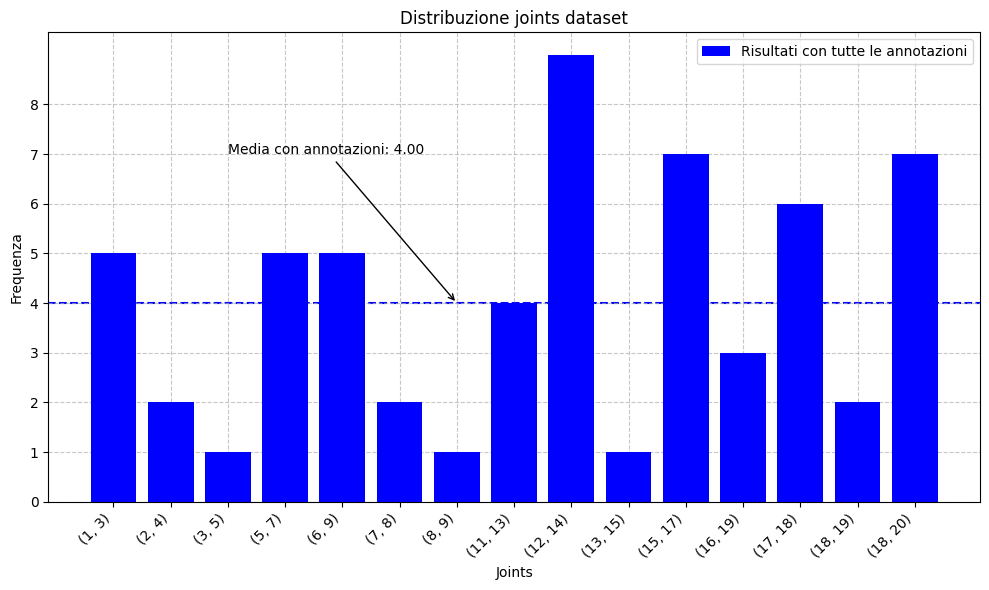

In [8]:
import matplotlib.pyplot as plt
from math import floor

labels2 = list(results.keys())
x_labels = list(sorted(list(set(labels2))))

y_values = [results[label] for label in x_labels ]

average = sum(y_values) / len(y_values)

#for i,value in reversed(list(enumerate(y_values))):
#    if value < floor(average):
#        x_labels.pop(i)
#        y_values.pop(i)

#average = sum(y_values)/len(y_values)

plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(average, color='blue', linestyle='--', zorder=0)
plt.bar(range(0,len(x_labels)), y_values, color='blue', label='Risultati con tutte le annotazioni')
plt.xticks(range(0,len(x_labels)),x_labels,rotation=45, ha='right')
plt.yticks(range(0,max(y_values)))
plt.xlabel('Joints')
plt.ylabel('Frequenza')
plt.title('Distribuzione joints dataset')

plt.annotate(f'Media con annotazioni: {average:.2f}', xy=(6, average), xytext=(2,average+3),
             arrowprops=dict(facecolor='blue', arrowstyle='->'), color='black')

plt.gca().set_axisbelow(True)
plt.legend()
plt.tight_layout()

plt.show()

## Machine Learning

#### Metrics
- Confusion Matrix

| Actual \ Predicted | False | True |
|---------|-----------|------------|
| False |   TN      |     FP     |
| True  |   FN      |     TP     |

- Precision:
 TP / (TP + FP)

- Specificity:
 TN / (TN + FP)

- Recall:
 TP / (TP + FN)

- F1 Score:
 2 * Precision * Recall / (Precision + Recall)


### Question 1: "To be edge or not to be edge? That is the question"

In [9]:
ANNOTATIONS_PATH = 'data'
dataset = pd.read_csv(os.path.join(ANNOTATIONS_PATH,'Dataset.csv'))

#### Final version

Is (12, 14)?


Double execution progression::   0%|          | 0/2 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

Executions not consistent!


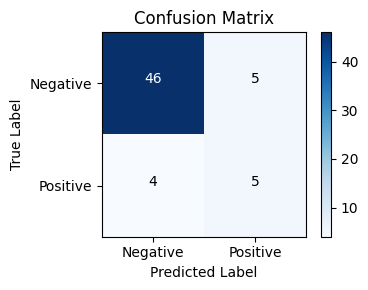

Accuracy:  0.85


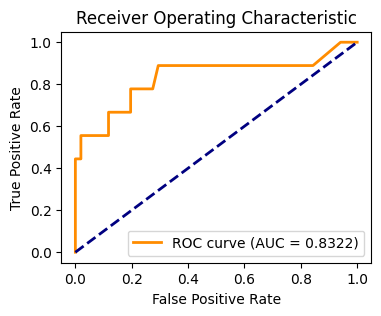

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier


target_label = list(dataset['OoM'].value_counts().index)[0]
question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
print(question)
labels = np.array((dataset['OoM'] == target_label).astype(int))
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []
seed = None#42

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    ratio = 0.4
    m_neigh = np.clip(int(labels_count[0] * ratio), 1, len(train_labels)) # The nearest neighbors used to determine if a minority sample is in "danger"
    k_neigh = np.clip(int(labels_count[1] * ratio), 1, len(train_labels)) # The nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples.
    

    # Fit the model with different hyperparameters using BorderlineSMOTE
    train_features_resampled, train_labels_resampled = BorderlineSMOTE(k_neighbors=k_neigh, m_neighbors=m_neigh, random_state=seed).fit_resample(train_features, train_labels)

    rf = RandomForestClassifier(n_estimators=500,random_state=seed)
    rf.fit(train_features_resampled,train_labels_resampled)

    # Sort the indices based on importances in descending order
    top_indices = np.argsort(np.array(rf.feature_importances_))[::-1][:50]

    train_important_features = train_features_resampled[:, top_indices]
    test_important_features = features[i, top_indices].reshape(1, -1)

    rf = RandomForestClassifier(n_estimators=200, max_features=None,random_state=seed)
    rf.fit(train_important_features, train_labels_resampled)

    # Predict on the test instance
    rf_prediction = rf.predict_proba(test_important_features)

    return labels[i], rf_prediction[0][1]

# Number of iterations (n)
n = len(features)
results_per_iter = []

if seed is None:
    for _ in tqdm(range(2),desc="Double execution progression:"):
        # Create a ThreadPoolExecutor (use ProcessPoolExecutor for processes)
        with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results_per_iter.append(list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: ",leave=False)))

    consistent_results = True
    for i in range(n):
        if tuple(map(round, results_per_iter[0][i])) != tuple(map(round, results_per_iter[1][i])):
            consistent_results = False
            print("\033[91mExecutions not consistent!\033[0m")
            break
    if consistent_results:
        print("\033[92mExecutions are consistent!\033[0m")

    results = results_per_iter[0]
else:
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [11]:
consistent_results = True
for i in range(n):
    if tuple(map(round, results_per_iter[0][i])) != tuple(map(round, results_per_iter[1][i])):
        print(results_per_iter[0][i], results_per_iter[1][i])
        consistent_results = False
        print("\033[91mExecutions not consistent!\033[0m")
        #break
if consistent_results:
    print("\033[92mExecutions are consistent!\033[0m")

(0, 0.55) (0, 0.325)
Executions not consistent!
(0, 0.63) (0, 0.385)
Executions not consistent!
(0, 0.54) (0, 0.33)
Executions not consistent!
(0, 0.49) (0, 0.505)
Executions not consistent!


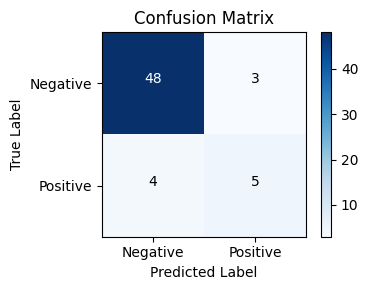

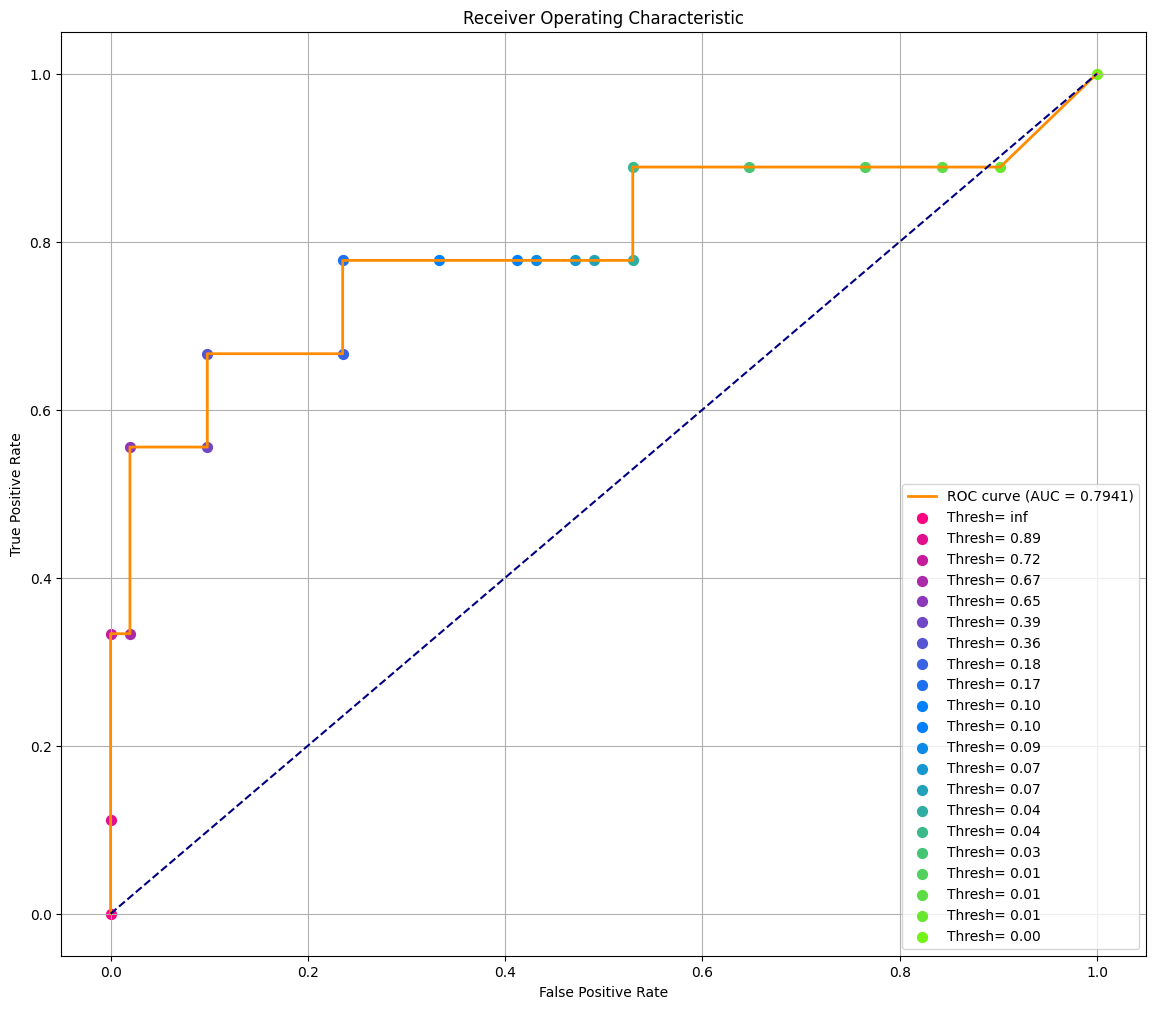

In [12]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
results = results_per_iter[1]

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

fpr, tpr, thresholds = roc_curve(y_true, (np.array(y_score) > 0.27).astype(int))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(14,12))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Plot classification threshold markers
import numpy as np

# Define the starting and ending colors as RGB tuples
start_color = (255, 0, 128)  # Red
intermediary_color = ( 0, 128, 255)  # Blue
end_color = (128, 255, 0)    # Green

# Number of colors to generate (including the endpoints)
n_colors = len(thresholds)

# Create a list of RGB colors along the linear gradient
colors = []
for i in range(n_colors):
    # Interpolate RGB values linearly between start and end colors
    r = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[0], intermediary_color[0]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[0], end_color[0]], left=0))
    g = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[1], intermediary_color[1]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[1], end_color[1]], left=0))
    b = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[2], intermediary_color[2]], right=0) + 
        np.interp(i, [n_colors // 2, n_colors], [intermediary_color[2], end_color[2]], left=0))
    colors.append(f'#{r:02X}{g:02X}{b:02X}')

for index, thresh in enumerate(thresholds):
    plt.scatter(fpr[index], tpr[index], marker='o', color=colors[index], label=f'Thresh= {thresholds[index]:.2f}', s=50, zorder=0)

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


#### Balanced class weight & RandomSearch hyperparam tuning & sensitivity as score

In [14]:
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import LeaveOneOut
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, recall_score, precision_score
from tqdm.notebook import tqdm

target_label = list(dataset['OoM'].value_counts().index)[0]
question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
print(question)
dataset[question] = dataset['OoM'] == target_label
labels = np.array(dataset[question].astype(int))
features = np.array(dataset.drop('OoM',axis=1).drop(question,axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []

# Define a parameter distribution to sample from
param_dist = {
    'n_estimators': randint(10, 400),
    #'max_depth': randint(2, 10),
    #'min_samples_split': randint(2, 5)
}

rf = RandomForestClassifier(n_jobs=-1,random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1, scoring=make_scorer(accuracy_score))

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 300]
}

# Create a GridSearchCV object
grid_search = GridSearchCV( estimator=rf, param_grid=param_grid, cv=LeaveOneOut(), scoring=make_scorer(accuracy_score), n_jobs=-1)

sampler = RandomUnderSampler(random_state=42)

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    
    t,s = sampler.fit_resample(train_features, train_labels)
    print(len(s))
    # Fit the model with different hyperparameters
    #random_search.fit(train_features,train_labels)
    grid_search.fit(t,s)
    print(pd.DataFrame(grid_search.cv_results_))
    rf = grid_search.best_estimator_
    
    # Train the model on training data
    #rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])
    cm = confusion_matrix(y_class_true,y_class_pred,labels=[0,1])
    print(f"TN:{cm[0,0]} FP:{cm[0,1]} FN:{cm[1,0]} TP:{cm[1,1]}",end='\r')

# Print confusion matrix and accuracy
print("Confusion Matrix:       ")
print(confusion_matrix(y_class_true, y_class_pred))
y_true = y_class_true
y_pred = y_class_pred
print(accuracy_score(y_true,y_pred), recall_score(y_true,y_pred), precision_score(y_true,y_pred))

Is (12, 14)?


  0%|          | 0/60 [00:00<?, ?it/s]

18
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.471964      0.056664         0.077554        0.020196   
1       1.240102      0.118160         0.132588        0.044583   

  param_n_estimators                 params  split0_test_score  \
0                100  {'n_estimators': 100}                1.0   
1                300  {'n_estimators': 300}                1.0   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0                1.0                1.0                1.0  ...   
1                1.0                1.0                1.0  ...   

   split11_test_score  split12_test_score  split13_test_score  \
0                 0.0                 1.0                 1.0   
1                 0.0                 1.0                 1.0   

   split14_test_score  split15_test_score  split16_test_score  \
0                 1.0                 1.0                 0.0   
1                 1.0                 1.0                 0.0   

  

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
y_true = y_class_true
y_pred = y_class_pred
cm = confusion_matrix(y_true,y_pred,labels=[0,1])
print(cm)
print(accuracy_score(y_true,y_pred), recall_score(y_true,y_pred), precision_score(y_true,y_pred))

[[40 11]
 [ 3  6]]
0.7666666666666667 0.6666666666666666 0.35294117647058826


#### Balanced class weight

In [ ]:
rf = RandomForestClassifier(n_estimators=class_weight='balanced_subsample',n_jobs=-1)
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])
    
y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))

  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 9  0]]


#### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


rf = RandomForestClassifier(n_jobs=-1)
ros = RandomOverSampler()
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ros.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))

  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 7  2]]


#### Undersampling

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


rf = RandomForestClassifier(n_jobs=-1, n_estimators = 500)
ruc = RandomUnderSampler(replacement=True)
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ruc.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)

  0%|          | 0/60 [00:00<?, ?it/s]

[[33 18]
 [ 2  7]]


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

rf = RandomForestClassifier(n_estimators=3000)
ruc = RandomUnderSampler()
n = len(labels)
y_true = []
y_scores = []

# Define a function for model training and prediction
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ruc.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)

    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)  # Get prediction probabilities

    return test_labels, rf_prediction[0]

# Create a ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n))


y_true = np.array(y_true)
y_scores = np.array(y_scores)
print(confusion_matrix(y_true,y_pred))
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


  0%|          | 0/60 [00:00<?, ?it/s]

/home/gagg/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:882: RuntimeWarning: divide by zero encountered in divide
  proba /= len(self.estimators_)


AttributeError: 'list' object has no attribute 'take'

#### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE()

n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)

  0%|          | 0/60 [00:00<?, ?it/s]

[[50  1]
 [ 6  3]]


#### Borderline-SMOTE

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

rf = RandomForestClassifier(n_jobs=-1)
# Create an instance of Borderline-SMOTE
borderline_smote = BorderlineSMOTE()
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = borderline_smote.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)


  0%|          | 0/60 [00:00<?, ?it/s]

[[49  2]
 [ 6  3]]


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor  # Use ThreadPoolExecutor or ProcessPoolExecutor
from sklearn.metrics import confusion_matrix

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    ratio = len(train_labels)//1.3
    m_neigh = np.clip(int(labels_count[0]/len(train_labels)*ratio),1,len(train_labels))
    k_neigh = np.clip(int(labels_count[1]/len(train_labels)*ratio),1,len(train_labels))

    # Fit the model with different hyperparameters using BorderlineSMOTE
    sampler = BorderlineSMOTE(k_neighbors=k_neigh,m_neighbors=m_neigh)    
    
    rf = RandomForestClassifier(n_estimators= 1000)
    rf.fit(*sampler.fit_resample(train_features, train_labels))

    # Get numerical feature importances
    #importances = list(rf.feature_importances_)
    #importances_array = np.array(importances)
    #indices_above_threshold = np.where(importances_array > 0.1)[0]  # Get the indices
    #importances_above_threshold = importances_array[importances_array > 0.1]  #

    # Sort the feature importances by most important first
    #feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Predict on the test instance
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)

    return test_labels, rf_prediction[0]

# Number of iterations (n)
n = len(features)

# Create a ThreadPoolExecutor (use ProcessPoolExecutor for processes)
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n))

# Separate the true labels and predicted labels from the results
y_class_true, y_class_pred = zip(*results)

print(confusion_matrix(y_class_true, y_class_pred, labels=[0, 1]))

  0%|          | 0/60 [00:00<?, ?it/s]

[[50  1]
 [ 6  3]]


In [ ]:
# loocv to automatically evaluate the performance of a random forest classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE

# Create an instance of Borderline-SMOTE
borderline_smote = BorderlineSMOTE(k_neighbors=1,m_neighbors=5)
features_resampled, labels_resampled = borderline_smote.fit_resample(features, labels)
print(borderline_smote.get_params())

# create model
rf = RandomForestClassifier(n_estimators=300)
# Define a parameter grid to search over
param_grid = {
    'n_estimators': list(range(100,700,50))
}

# Create a GridSearchCV object
grid_search = GridSearchCV( estimator=rf, param_grid=param_grid, scoring=make_scorer(accuracy_score), n_jobs=-1)
# evaluate model
predictions = cross_val_predict(rf, features_resampled, labels_resampled, cv=LeaveOneOut(), n_jobs=-1,verbose=1)
# report performance
print('Conf mat:\n', confusion_matrix(labels_resampled,predictions))

{'k_neighbors': 1, 'kind': 'borderline-1', 'm_neighbors': 5, 'n_jobs': None, 'random_state': None, 'sampling_strategy': 'auto'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s


Conf mat:
 [[50  1]
 [ 1 50]]


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   17.7s finished


#### Adasyn

In [ ]:
from imblearn.over_sampling import ADASYN

rf = RandomForestClassifier(n_jobs=-1)
# Create an instance of adasyn
adasyn = ADASYN(sampling_strategy='auto')
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = adasyn.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)


  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 5  4]]


### Question 2: "Top or Bottom?"

Double execution progression::   0%|          | 0/2 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

Executions not consistent!


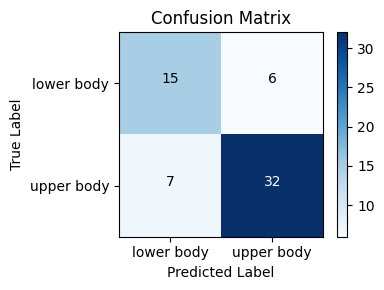

Accuracy:  0.7833333333333333


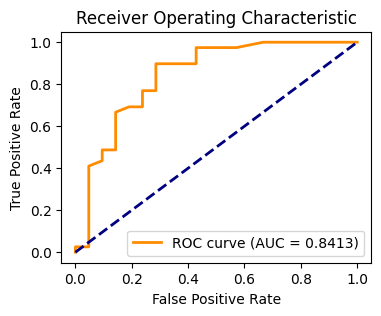

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier

ord_edge_groups = {0: [0,1,2,3,4,5,6], 1:[7,8,9,10,11,12,13,14]}
group_names = {0: "lower body", 1: "upper body"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}

labels = np.array(dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])).astype(int)
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []
seed = None#42

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    ratio = 0.4
    m_neigh = np.clip(int(labels_count[0] * ratio), 1, len(train_labels)) # The nearest neighbors used to determine if a minority sample is in "danger"
    k_neigh = np.clip(int(labels_count[1] * ratio), 1, len(train_labels)) # The nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples.
    

    # Fit the model with different hyperparameters using BorderlineSMOTE
    train_features_resampled, train_labels_resampled = BorderlineSMOTE(k_neighbors=k_neigh, m_neighbors=m_neigh, random_state=seed).fit_resample(train_features, train_labels)

    rf = RandomForestClassifier(n_estimators=500,random_state=seed)
    rf.fit(train_features_resampled,train_labels_resampled)

    # Sort the indices based on importances in descending order
    top_indices = np.argsort(np.array(rf.feature_importances_))[::-1][:50]

    train_important_features = train_features_resampled[:, top_indices]
    test_important_features = features[i, top_indices].reshape(1, -1)

    rf = RandomForestClassifier(n_estimators=200, max_features=None,random_state=seed)
    rf.fit(train_important_features, train_labels_resampled)

    # Predict on the test instance
    rf_prediction = rf.predict_proba(test_important_features)

    return labels[i], rf_prediction[0][1]

# Number of iterations (n)
n = len(features)
results_per_iter = []

if seed is None:
    for _ in tqdm(range(2),desc="Double execution progression:"):
        # Create a ThreadPoolExecutor (use ProcessPoolExecutor for processes)
        with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results_per_iter.append(list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: ",leave=False)))

    consistent_results = True
    for i in range(n):
        if tuple(map(round, results_per_iter[0][i])) != tuple(map(round, results_per_iter[1][i])):
            consistent_results = False
            print("\033[91mExecutions not consistent!\033[0m")
            break
    if consistent_results:
        print("\033[92mExecutions are consistent!\033[0m")

    results = results_per_iter[0]
else:
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = [group_names[0], group_names[1]]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [16]:
consistent_results = True
for i in range(n):
    if tuple(map(round, results_per_iter[0][i])) != tuple(map(round, results_per_iter[1][i])):
        print(results_per_iter[0][i], results_per_iter[1][i])
        consistent_results = False
        print("\033[91mExecutions not consistent!\033[0m")
        #break
if consistent_results:
    print("\033[92mExecutions are consistent!\033[0m")

(0, 0.38) (0, 0.505)
Executions not consistent!
(1, 0.645) (1, 0.45)
Executions not consistent!
(1, 0.485) (1, 0.53)
Executions not consistent!


0.75


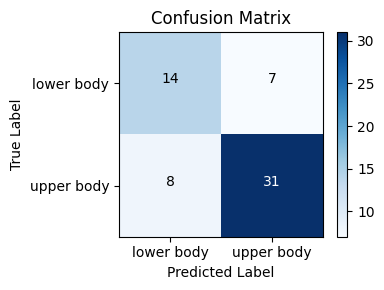

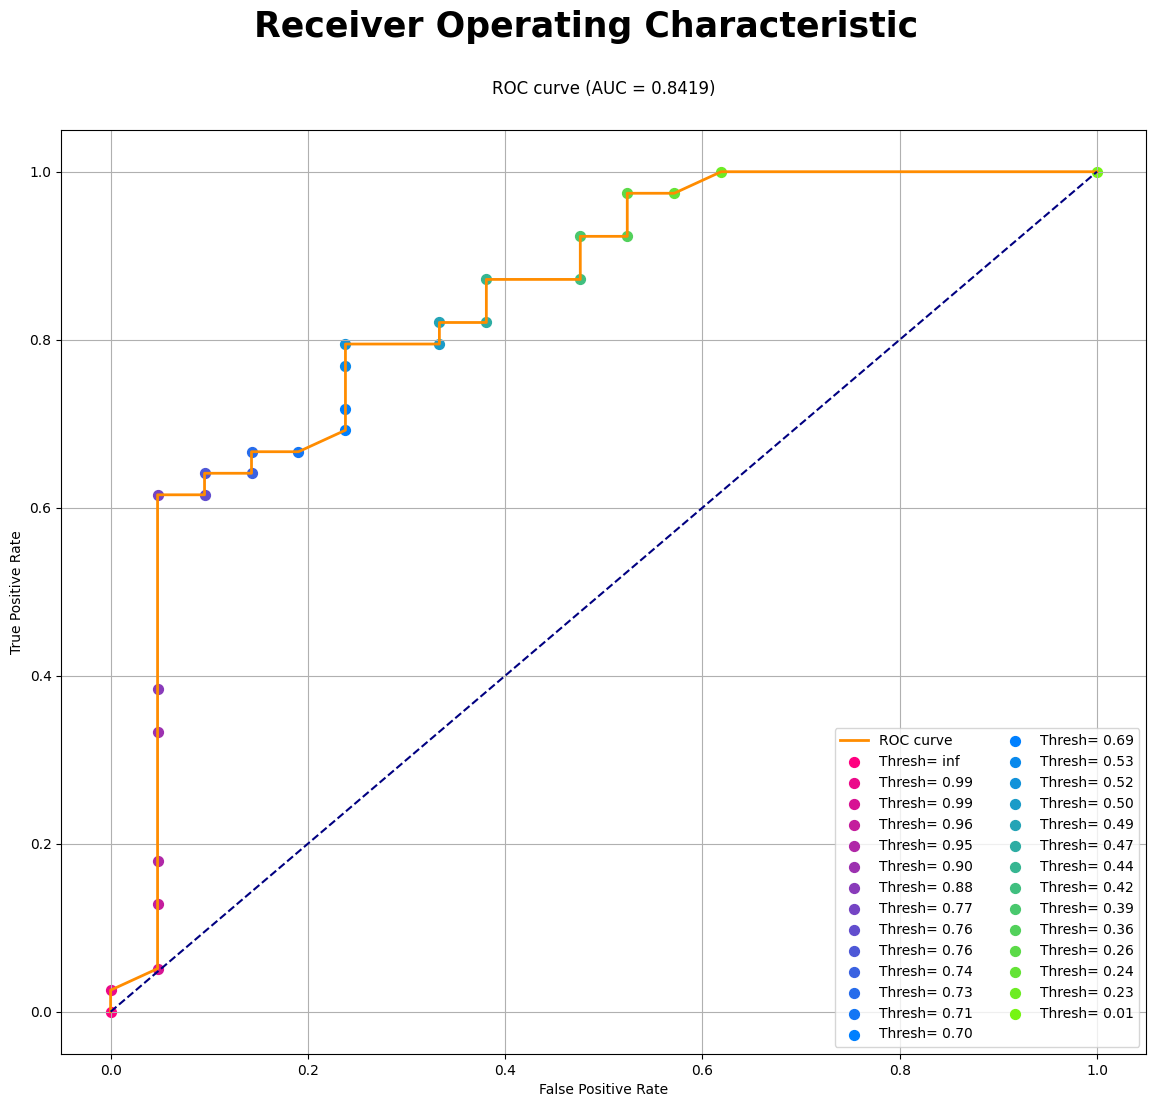

In [17]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
results = results_per_iter[1]

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = [group_names[0], group_names[1]]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
print(accuracy)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(14,12))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')

# Plot classification threshold markers
import numpy as np

# Define the starting and ending colors as RGB tuples
start_color = (255, 0, 128)  # Red
intermediary_color = ( 0, 128, 255)  # Blue
end_color = (128, 255, 0)    # Green

# Number of colors to generate (including the endpoints)
n_colors = len(thresholds)

# Create a list of RGB colors along the linear gradient
colors = []
for i in range(n_colors):
    # Interpolate RGB values linearly between start and end colors
    r = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[0], intermediary_color[0]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[0], end_color[0]], left=0))
    g = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[1], intermediary_color[1]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[1], end_color[1]], left=0))
    b = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[2], intermediary_color[2]], right=0) + 
        np.interp(i, [n_colors // 2, n_colors], [intermediary_color[2], end_color[2]], left=0))
    colors.append(f'#{r:02X}{g:02X}{b:02X}')

for index, thresh in enumerate(thresholds):
    plt.scatter(fpr[index], tpr[index], marker='o', color=colors[index], label=f'Thresh= {thresholds[index]:.2f}', s=50, zorder=0)
    # Display the label next to the marker
    #plt.text(fpr[index]-0.1, tpr[index]+0.1, f'Thresh={thresholds[index]:.2f}', fontsize=10, va='center', ha='left')

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC = {roc_auc:.4f})',y=1.03)
plt.suptitle('Receiver Operating Characteristic', fontweight='bold',fontsize=25)
plt.legend(loc='lower right', ncols=2)
plt.show()


### Question 3: "My face is here, whatcha u looking at?"

Double execution progression::   0%|          | 0/2 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

Executions not consistent!


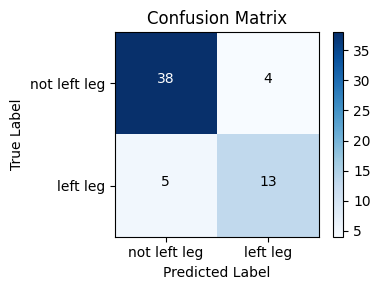

Accuracy:  0.85


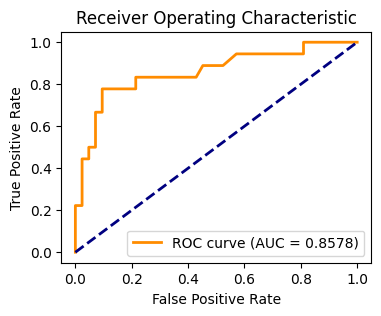

In [18]:
ord_edge_groups = {0: [0,2,3,5], 1:[1,4,6], 2:[7,9,10,12], 3:[8,11,13], 4:[14]}
group_names = {0: "right leg", 1: "left leg", 2:"right arm", 3:"left arm", 4:"head"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}

relabeled_OoM = dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])
target_label = list(relabeled_OoM.value_counts().index)[0]
labels = np.array(relabeled_OoM == target_label).astype(int)
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []
seed = None#42

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    ratio = 0.4
    m_neigh = np.clip(int(labels_count[0] * ratio), 1, len(train_labels)) # The nearest neighbors used to determine if a minority sample is in "danger"
    k_neigh = np.clip(int(labels_count[1] * ratio), 1, len(train_labels)) # The nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples.
    

    # Fit the model with different hyperparameters using BorderlineSMOTE
    train_features_resampled, train_labels_resampled = BorderlineSMOTE(k_neighbors=k_neigh, m_neighbors=m_neigh, random_state=seed).fit_resample(train_features, train_labels)

    rf = RandomForestClassifier(n_estimators=500,random_state=seed)
    rf.fit(train_features_resampled,train_labels_resampled)

    # Sort the indices based on importances in descending order
    top_indices = np.argsort(np.array(rf.feature_importances_))[::-1][:50]

    train_important_features = train_features_resampled[:, top_indices]
    test_important_features = features[i, top_indices].reshape(1, -1)

    rf = RandomForestClassifier(n_estimators=200, max_features=None,random_state=seed)
    rf.fit(train_important_features, train_labels_resampled)

    # Predict on the test instance
    rf_prediction = rf.predict_proba(test_important_features)

    return labels[i], rf_prediction[0][1]

# Number of iterations (n)
n = len(features)
results_per_iter = []

if seed is None:
    for _ in tqdm(range(2),desc="Double execution progression:"):
        # Create a ThreadPoolExecutor (use ProcessPoolExecutor for processes)
        with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results_per_iter.append(list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: ",leave=False)))

    consistent_results = True
    for i in range(n):
        if tuple(map(round, results_per_iter[0][i])) != tuple(map(round, results_per_iter[1][i])):
            consistent_results = False
            print("\033[91mExecutions not consistent!\033[0m")
            break
    if consistent_results:
        print("\033[92mExecutions are consistent!\033[0m")

    results = results_per_iter[0]
else:
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ["not "+group_names[1], group_names[1]]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

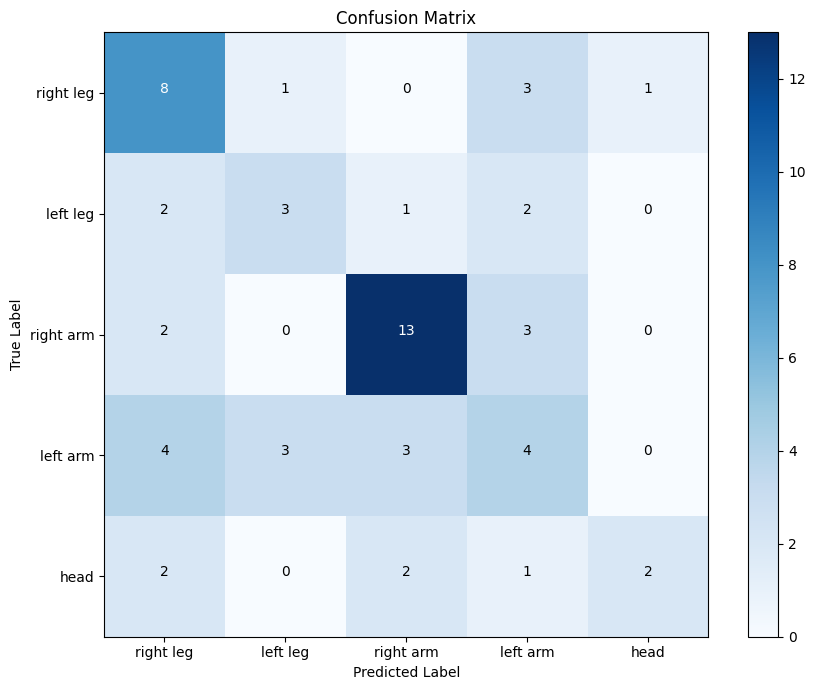

Accuracy:  0.5


ValueError: multiclass format is not supported

In [14]:
ord_edge_groups = {0: [0,2,3,5], 1:[1,4,6], 2:[7,9,10,12], 3:[8,11,13], 4:[14]}
group_names = {0: "right leg", 1: "left leg", 2:"right arm", 3:"left arm", 4:"head"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}

relabeled_OoM = dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])
#target_label = list(relabeled_OoM.value_counts().index)[0]
labels = np.array(relabeled_OoM).astype(int)
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []
seed = None#42

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    ratio = 0.4
    m_neigh = np.clip(int(labels_count[0] * ratio), 1, len(train_labels)) # The nearest neighbors used to determine if a minority sample is in "danger"
    k_neigh = np.clip(int(labels_count[1] * ratio), 1, len(train_labels)) # The nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples.
    

    # Fit the model with different hyperparameters using BorderlineSMOTE
    train_features_resampled, train_labels_resampled = BorderlineSMOTE(k_neighbors=k_neigh, m_neighbors=m_neigh, random_state=seed).fit_resample(train_features, train_labels)

    rf = RandomForestClassifier(n_estimators=500,random_state=seed)
    rf.fit(train_features_resampled,train_labels_resampled)

    # Sort the indices based on importances in descending order
    top_indices = np.argsort(np.array(rf.feature_importances_))[::-1][:50]

    train_important_features = train_features_resampled[:, top_indices]
    test_important_features = features[i, top_indices].reshape(1, -1)

    rf = RandomForestClassifier(n_estimators=200, max_features=None,random_state=seed)
    rf.fit(train_important_features, train_labels_resampled)

    # Predict on the test instance
    rf_prediction = rf.predict_proba(test_important_features)

    return labels[i], np.argmax(rf_prediction[0])

# Number of iterations (n)
n = len(features)

with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, y_score, labels=[0, 1, 2, 3, 4])
accuracy = accuracy_score(y_true, y_score)

# Plot the confusion matrix
plt.figure(figsize=(9, 7))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = list(group_names.values())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()